In [1]:
import numpy as np
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
from utilities_new_new import *
import matplotlib.pyplot as plt


c:\Users\Me\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_roc_2(classifier, X_train, y_test, label, plot):
    fpr, tpr, roc_auc = compute_roc(classifier, X_train, y_test)
    plot.plot(fpr, tpr, lw=2, label=label+f" (AUC = {roc_auc:.4f})")
    return plot

In [3]:
def plot_precision_recall_2(classifier, X_train, y_test, name, titlestring):
    plt.figure(figsize=(8, 8))
    precision_arr, recall_arr, pr_auc, chance_level = compute_precision_recall(classifier, X_train, y_test)
    plt.plot(recall_arr, precision_arr, lw=2, label=f"{name} (AUC = {pr_auc:.4f})")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1])
    plt.ylim([0.5, 1.0])
    plt.title(titlestring+'Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

In [4]:
def prepare_data_eFEX_GEP(data_subdir,accept_data_filename,reject_data_filename,distance_boundaries):
    save_path = os.path.join(os.path.pardir, "data", data_subdir)
    if os.path.exists(os.path.join(save_path, "np_data.npz")):
        print(f"found preprepared data in {save_path}")
        np_data = np.load(os.path.join(save_path, "np_data.npz"))
        input_np1, input_np2, labels_np = np_data["input_np1"], np_data["input_np2"], np_data["labels_np"]

    else:
        print(f"preprepared data in {save_path} is missing, preparing and saving here")
        accept_data_path = os.path.join(parent_dir, "data", accept_data_filename)
        reject_data_path = os.path.join(parent_dir, "data", reject_data_filename)
        DFs = import_data_files([accept_data_path, reject_data_path])
        accepted_numpy_eFEX = ak.to_numpy(DFs[0]['SuperCell_ET'])
        rejected_numpy_eFEX = ak.to_numpy(DFs[1]['SuperCell_ET'])
        print("attempting to generate topo training data")
        accepted_numpy_GEP = generate_topocluster_ET_distribution(DFs[0], distance_boundaries)
        rejected_numpy_GEP = generate_topocluster_ET_distribution(DFs[1], distance_boundaries)
        accepted_labels = np.ones(DFs[0].shape[0])
        rejected_labels = np.zeros(DFs[1].shape[0])    
        input_np1 = np.concatenate((accepted_numpy_eFEX, rejected_numpy_eFEX), axis=0)
        input_np2 = np.concatenate((accepted_numpy_GEP, rejected_numpy_GEP), axis=0)
        labels_np = np.concatenate((accepted_labels, rejected_labels), axis=0)
        
        if not os.path.exists(save_path):
                os.mkdir(save_path)
        np.savez(os.path.join(save_path,"np_data.npz"), input_np1=input_np1, input_np2=input_np2, labels_np=labels_np)

    return input_np1, input_np2, labels_np


In [5]:
def eFEX_GEP_loop(classifiers_1,classifiers_2,accept_data_filename,reject_data_filename,distance_boundaries,data_subdir):
    rejection_rates_heuristic =  [0.0, 0.8009311588352441, 0.8357150546315733, 0.8618870768071478]
    id_efficiencies_heuristic = [1.0, 0.9905439553132065, 0.9805160260672962, 0.9638515760074478]

    classifiers = import_all_classifiers()
    input_np1, input_np2, labels_np = prepare_data_eFEX_GEP(data_subdir,accept_data_filename,reject_data_filename,distance_boundaries)
    X_train, X_test, X_train_topo, X_test_topo, y_train, y_test = train_test_split(input_np1, input_np2, labels_np, test_size=0.2, random_state=42)

    for name_1 in classifiers_1:
        Classifier1 = classifiers[name_1]
        if name_1 == "VotingClassifier":
            clf = Classifier1(estimators=[("lr", LogisticRegression()), ("rf", RandomForestClassifier())], voting='soft')
        else:
            clf = Classifier1()
        clf.fit(X_train, y_train)

        if hasattr(clf, "decision_function"):  # For models like SVM or SGD
            y_scores = clf.decision_function(X_test)
        elif hasattr(clf, "predict_proba"):  # For models like XGBoost or other tree-based models
            probs = clf.predict_proba(X_test)
            y_scores = probs[:, 1] if probs.shape[1] > 1 else probs[:, 0]

        X_test_extended = np.hstack((X_test_topo, y_scores.reshape(-1, 1))) #not sure about reshaping
        X_train2, X_test2, X_train3, X_test3, y_train2, y_test2 = train_test_split(X_test_extended, X_test, y_test, test_size=0.2, random_state=42)
        
        print("before second training with topo: (eFEX)")
        y_pred1 = clf.predict(X_test3)
        tn, fp, fn, tp, accuracy, recall, precision, f1, mse = evaluate_sklearn_model(y_test2, y_pred1, classifier_name=f'{name_1}')
        # fig, ax= plt.subplots()
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 8))
        plt = plot_roc_2(clf, X_test3, y_test2, name_1+" (eFEX)",plt)
        # plot_precision_recall_2(clf, X_test3, y_test2, name_1, "eFEX decision")

        for name_2 in classifiers_2:
            Classifier2 = classifiers[name_2]
            if name_2 == "VotingClassifier":
                clf2 = Classifier2(estimators=[("lr", LogisticRegression()), ("rf", RandomForestClassifier())], voting='soft')
            else:
                clf2 = Classifier2()

            clf2.fit(X_train2, y_train2)

            print("after second training with topo: (eFEX + GEP)")
            y_pred2 = clf2.predict(X_test2)
            tn, fp, fn, tp, accuracy, recall, precision, f1, mse = evaluate_sklearn_model(y_test2, y_pred2, classifier_name=f'{name_2}')
            plt = plot_roc_2(clf2, X_test2, y_test2, f"{name_1} (eFEX) + {name_2} (GEP)", plt)
            # plot_precision_recall_2(clf2, X_test2, y_test2, name_2, "eFEX decision + topocluster ([0.0125,0.025,0.05,0.1,0.2,0.4] ring))")

        for i in range(1,4):
            # plt.scatter(1.-rejection_rates_heuristic[i],id_efficiencies_heuristic[i], color='r', marker='s', label='Heuristic' if i == 1 else '')
            plt.scatter(1.-rejection_rates_heuristic[i],id_efficiencies_heuristic[i], color='r', marker='s')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 0.2])
        plt.ylim([0.92, 1.0])
        plt.xlabel('False Positive Rate (Electron Efficiency)')
        plt.ylabel('True Positive Rate (Jet Survivial Probability)')
        plt.title('eFEX + GEP ROC Curve Comparison')
        plt.legend(loc='lower left')
        plt.show()

Imported 43 binary classifiers:
['AdaBoostClassifier', 'BaggingClassifier', 'BernoulliNB', 'CalibratedClassifierCV', 'CategoricalNB', 'ClassifierChain', 'ComplementNB', 'DecisionTreeClassifier', 'DummyClassifier', 'ExtraTreeClassifier', 'ExtraTreesClassifier', 'FixedThresholdClassifier', 'GaussianNB', 'GaussianProcessClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier', 'KNeighborsClassifier', 'LabelPropagation', 'LabelSpreading', 'LinearDiscriminantAnalysis', 'LinearSVC', 'LogisticRegression', 'LogisticRegressionCV', 'MLPClassifier', 'MultiOutputClassifier', 'MultinomialNB', 'NearestCentroid', 'NuSVC', 'OneVsOneClassifier', 'OneVsRestClassifier', 'OutputCodeClassifier', 'PassiveAggressiveClassifier', 'Perceptron', 'QuadraticDiscriminantAnalysis', 'RadiusNeighborsClassifier', 'RandomForestClassifier', 'RidgeClassifier', 'RidgeClassifierCV', 'SGDClassifier', 'SVC', 'TunedThresholdClassifierCV', 'VotingClassifier', 'XGBClassifier']
found preprepared data in ..\data

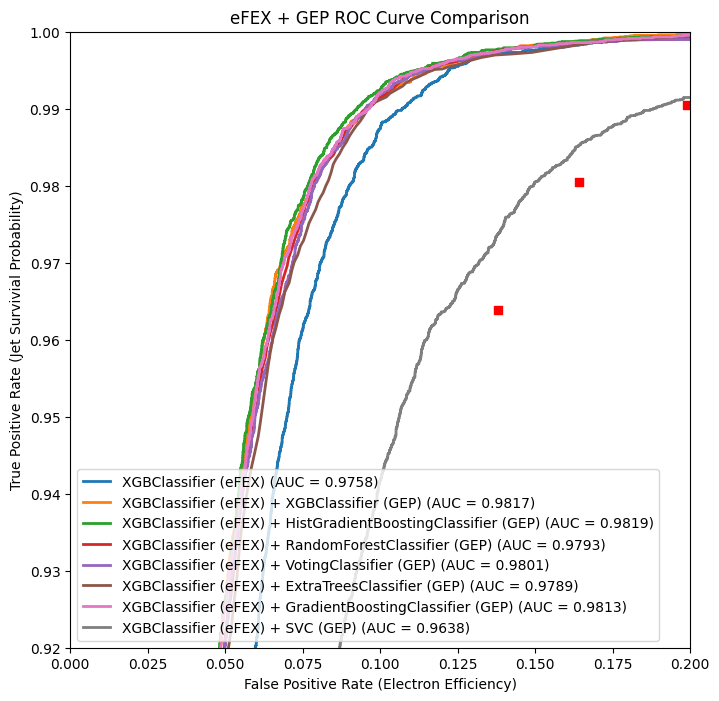

before second training with topo: (eFEX)


Evaluation of MLPClassifier
Confusion Matrix:
 [[19907  1515]
 [  464 14406]]
Accuracy: 0.94547008
Recall: 0.96879623
Precision: 0.90484266
F1 Score: 0.93572797
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.93      0.95     21422
         1.0       0.90      0.97      0.94     14870

    accuracy                           0.95     36292
   macro avg       0.94      0.95      0.94     36292
weighted avg       0.95      0.95      0.95     36292

Mean Squared Error: 0.05452992

after second training with topo: (eFEX + GEP)


Evaluation of XGBClassifier
Confusion Matrix:
 [[20072  1350]
 [  480 14390]]
Accuracy: 0.94957566
Recall: 0.96772024
Precision: 0.91423126
F1 Score: 0.94021562
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.94      0.96     21422
         1.0       0.91      0.97      0.94     14870

    accuracy    

c:\Users\Me\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


after second training with topo: (eFEX + GEP)


Evaluation of VotingClassifier
Confusion Matrix:
 [[20067  1355]
 [  457 14413]]
Accuracy: 0.95007164
Recall: 0.96926698
Precision: 0.91406646
F1 Score: 0.94085776
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.94      0.96     21422
         1.0       0.91      0.97      0.94     14870

    accuracy                           0.95     36292
   macro avg       0.95      0.95      0.95     36292
weighted avg       0.95      0.95      0.95     36292

Mean Squared Error: 0.04992836

after second training with topo: (eFEX + GEP)


Evaluation of ExtraTreesClassifier
Confusion Matrix:
 [[20046  1376]
 [  495 14375]]
Accuracy: 0.94844594
Recall: 0.96671150
Precision: 0.91264047
F1 Score: 0.93889814
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.94      0.96     21422
         1.0       0.91      0.97      0.94     14870

 

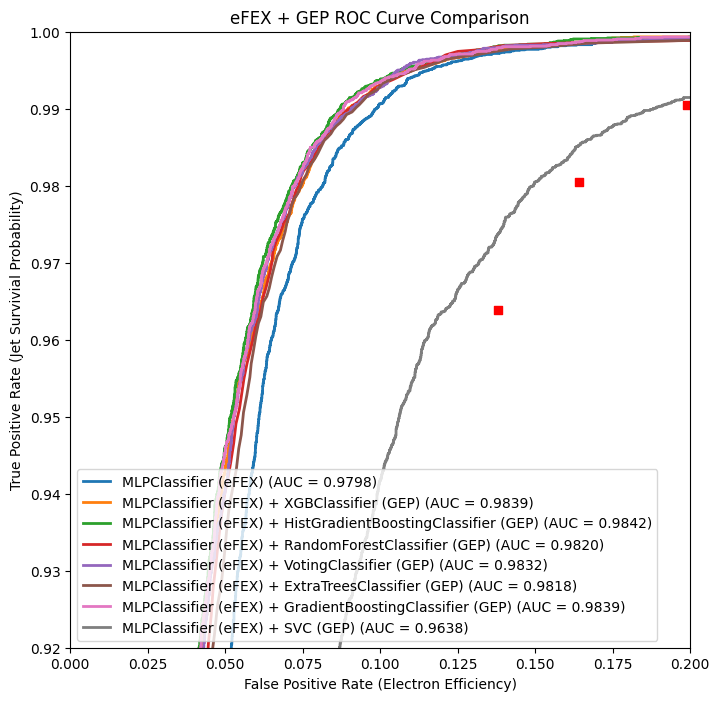

before second training with topo: (eFEX)


Evaluation of ExtraTreesClassifier
Confusion Matrix:
 [[19704  1718]
 [  402 14468]]
Accuracy: 0.94158492
Recall: 0.97296570
Precision: 0.89385889
F1 Score: 0.93173622
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.92      0.95     21422
         1.0       0.89      0.97      0.93     14870

    accuracy                           0.94     36292
   macro avg       0.94      0.95      0.94     36292
weighted avg       0.94      0.94      0.94     36292

Mean Squared Error: 0.05841508

after second training with topo: (eFEX + GEP)


Evaluation of XGBClassifier
Confusion Matrix:
 [[20041  1381]
 [  505 14365]]
Accuracy: 0.94803262
Recall: 0.96603900
Precision: 0.91229519
F1 Score: 0.93839822
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.94      0.96     21422
         1.0       0.91      0.97      0.94     14870

    accur

c:\Users\Me\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


after second training with topo: (eFEX + GEP)


Evaluation of VotingClassifier
Confusion Matrix:
 [[20027  1395]
 [  484 14386]]
Accuracy: 0.94822550
Recall: 0.96745124
Precision: 0.91160256
F1 Score: 0.93869694
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.93      0.96     21422
         1.0       0.91      0.97      0.94     14870

    accuracy                           0.95     36292
   macro avg       0.94      0.95      0.95     36292
weighted avg       0.95      0.95      0.95     36292

Mean Squared Error: 0.05177450

after second training with topo: (eFEX + GEP)


Evaluation of ExtraTreesClassifier
Confusion Matrix:
 [[19995  1427]
 [  546 14324]]
Accuracy: 0.94563540
Recall: 0.96328178
Precision: 0.90940258
F1 Score: 0.93556709
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     21422
         1.0       0.91      0.96      0.94     14870

 

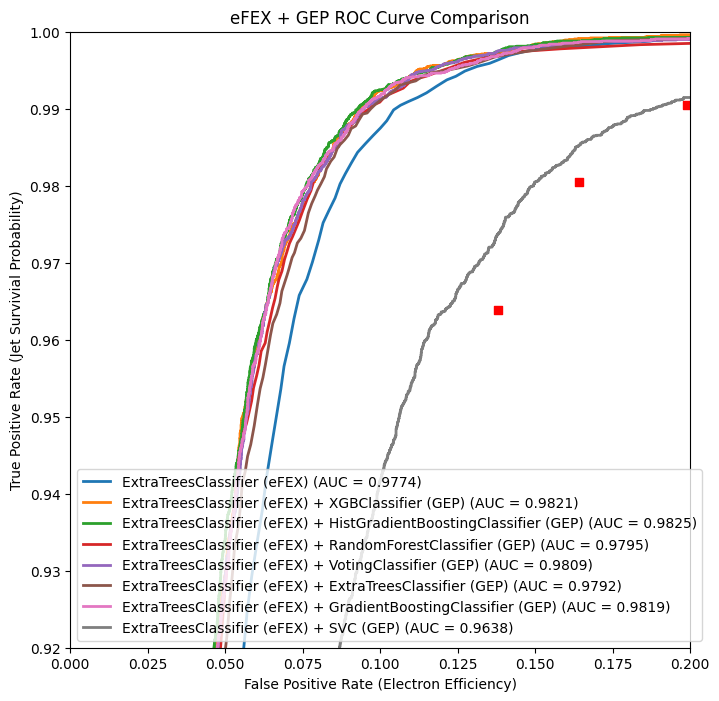

before second training with topo: (eFEX)


Evaluation of HistGradientBoostingClassifier
Confusion Matrix:
 [[19628  1794]
 [  475 14395]]
Accuracy: 0.93747933
Recall: 0.96805649
Precision: 0.88918401
F1 Score: 0.92694549
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.92      0.95     21422
         1.0       0.89      0.97      0.93     14870

    accuracy                           0.94     36292
   macro avg       0.93      0.94      0.94     36292
weighted avg       0.94      0.94      0.94     36292

Mean Squared Error: 0.06252067

after second training with topo: (eFEX + GEP)


Evaluation of XGBClassifier
Confusion Matrix:
 [[19963  1459]
 [  466 14404]]
Accuracy: 0.94695801
Recall: 0.96866174
Precision: 0.90802496
F1 Score: 0.93736375
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.93      0.95     21422
         1.0       0.91      0.97      0.94     14870


c:\Users\Me\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


after second training with topo: (eFEX + GEP)


Evaluation of VotingClassifier
Confusion Matrix:
 [[19881  1541]
 [  422 14448]]
Accuracy: 0.94591094
Recall: 0.97162071
Precision: 0.90362124
F1 Score: 0.93638809
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.93      0.95     21422
         1.0       0.90      0.97      0.94     14870

    accuracy                           0.95     36292
   macro avg       0.94      0.95      0.94     36292
weighted avg       0.95      0.95      0.95     36292

Mean Squared Error: 0.05408906

after second training with topo: (eFEX + GEP)


Evaluation of ExtraTreesClassifier
Confusion Matrix:
 [[19929  1493]
 [  493 14377]]
Accuracy: 0.94527720
Recall: 0.96684600
Precision: 0.90592313
F1 Score: 0.93539362
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.93      0.95     21422
         1.0       0.91      0.97      0.94     14870

 

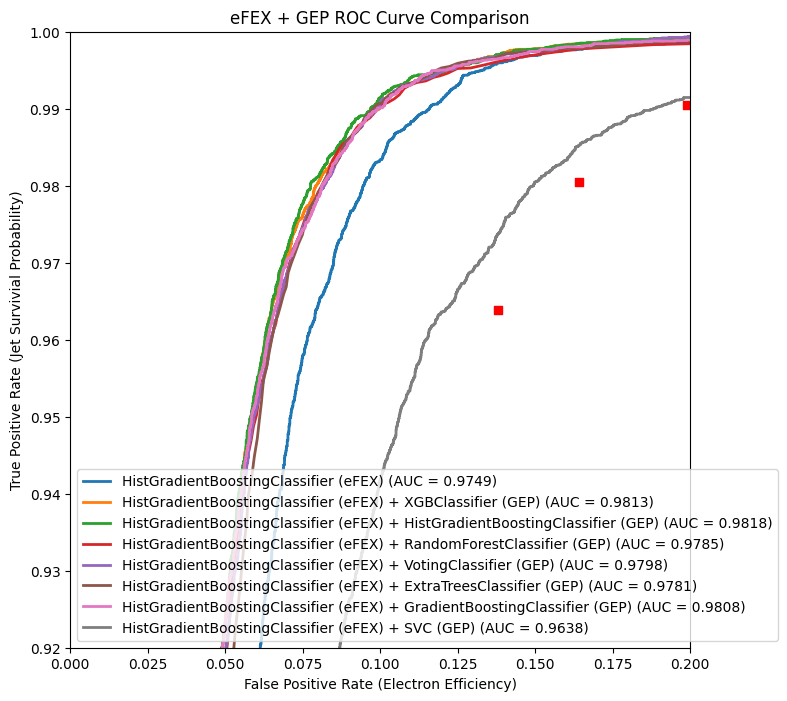

before second training with topo: (eFEX)


Evaluation of RandomForestClassifier
Confusion Matrix:
 [[19778  1644]
 [  529 14341]]
Accuracy: 0.94012455
Recall: 0.96442502
Precision: 0.89715358
F1 Score: 0.92957381
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.92      0.95     21422
         1.0       0.90      0.96      0.93     14870

    accuracy                           0.94     36292
   macro avg       0.94      0.94      0.94     36292
weighted avg       0.94      0.94      0.94     36292

Mean Squared Error: 0.05987545

after second training with topo: (eFEX + GEP)


Evaluation of XGBClassifier
Confusion Matrix:
 [[20047  1375]
 [  528 14342]]
Accuracy: 0.94756420
Recall: 0.96449227
Precision: 0.91251511
F1 Score: 0.93778403
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.95     21422
         1.0       0.91      0.96      0.94     14870

    acc

c:\Users\Me\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


after second training with topo: (eFEX + GEP)


Evaluation of VotingClassifier
Confusion Matrix:
 [[20054  1368]
 [  537 14333]]
Accuracy: 0.94750909
Recall: 0.96388702
Precision: 0.91287179
F1 Score: 0.93768604
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.95     21422
         1.0       0.91      0.96      0.94     14870

    accuracy                           0.95     36292
   macro avg       0.94      0.95      0.95     36292
weighted avg       0.95      0.95      0.95     36292

Mean Squared Error: 0.05249091

after second training with topo: (eFEX + GEP)


Evaluation of ExtraTreesClassifier
Confusion Matrix:
 [[20033  1389]
 [  552 14318]]
Accuracy: 0.94651714
Recall: 0.96287828
Precision: 0.91156809
F1 Score: 0.93652091
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.95     21422
         1.0       0.91      0.96      0.94     14870

 

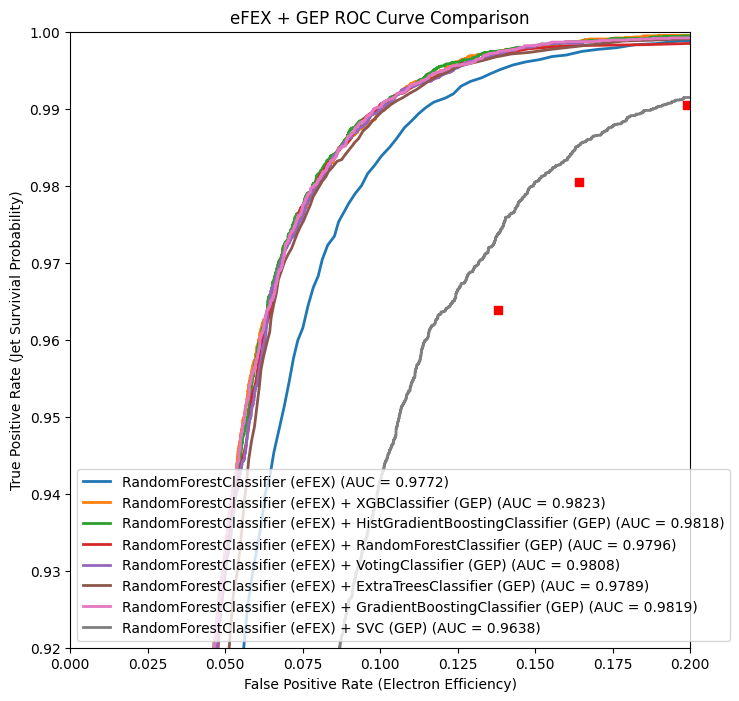

c:\Users\Me\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


before second training with topo: (eFEX)


Evaluation of VotingClassifier
Confusion Matrix:
 [[19345  2077]
 [  508 14362]]
Accuracy: 0.92877218
Recall: 0.96583726
Precision: 0.87365412
F1 Score: 0.91743588
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.94     21422
         1.0       0.87      0.97      0.92     14870

    accuracy                           0.93     36292
   macro avg       0.92      0.93      0.93     36292
weighted avg       0.93      0.93      0.93     36292

Mean Squared Error: 0.07122782

after second training with topo: (eFEX + GEP)


Evaluation of XGBClassifier
Confusion Matrix:
 [[19908  1514]
 [  622 14248]]
Accuracy: 0.94114405
Recall: 0.95817081
Precision: 0.90394620
F1 Score: 0.93026900
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     21422
         1.0       0.90      0.96      0.93     14870

    accuracy 

c:\Users\Me\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


after second training with topo: (eFEX + GEP)


Evaluation of VotingClassifier
Confusion Matrix:
 [[19893  1529]
 [  616 14254]]
Accuracy: 0.94089607
Recall: 0.95857431
Precision: 0.90312361
F1 Score: 0.93002316
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     21422
         1.0       0.90      0.96      0.93     14870

    accuracy                           0.94     36292
   macro avg       0.94      0.94      0.94     36292
weighted avg       0.94      0.94      0.94     36292

Mean Squared Error: 0.05910393

after second training with topo: (eFEX + GEP)


Evaluation of ExtraTreesClassifier
Confusion Matrix:
 [[19895  1527]
 [  645 14225]]
Accuracy: 0.94015210
Recall: 0.95662408
Precision: 0.90305993
F1 Score: 0.92907060
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     21422
         1.0       0.90      0.96      0.93     14870

 

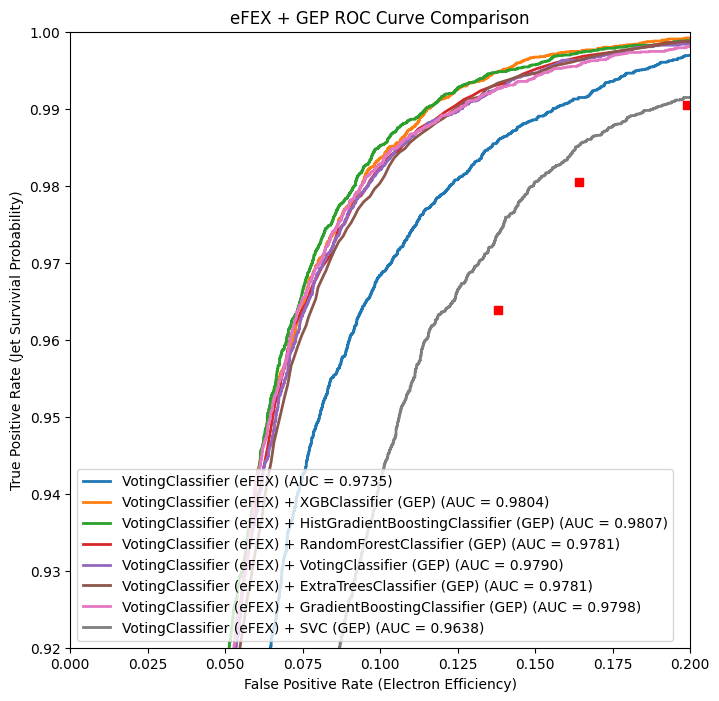

In [6]:
name = "XGBClassifier"
data_subdir = "eFEX_GEP_test"
accept_data_filename = "l1calo_topocluster_test_Zee.root"
reject_data_filename = "ZMUMU_TopoCluster_Supercell_Large.root"
distance_boundaries = [0.0125,0.025,0.05,0.1,0.2,0.4]

classifiers_1 = ["XGBClassifier","MLPClassifier","ExtraTreesClassifier","HistGradientBoostingClassifier","RandomForestClassifier","VotingClassifier"]
classifiers_2 = ["XGBClassifier","HistGradientBoostingClassifier","RandomForestClassifier","VotingClassifier","ExtraTreesClassifier","GradientBoostingClassifier","SVC"]

eFEX_GEP_loop(classifiers_1,classifiers_2,accept_data_filename,reject_data_filename,distance_boundaries,data_subdir)

Imported 43 binary classifiers:
['AdaBoostClassifier', 'BaggingClassifier', 'BernoulliNB', 'CalibratedClassifierCV', 'CategoricalNB', 'ClassifierChain', 'ComplementNB', 'DecisionTreeClassifier', 'DummyClassifier', 'ExtraTreeClassifier', 'ExtraTreesClassifier', 'FixedThresholdClassifier', 'GaussianNB', 'GaussianProcessClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier', 'KNeighborsClassifier', 'LabelPropagation', 'LabelSpreading', 'LinearDiscriminantAnalysis', 'LinearSVC', 'LogisticRegression', 'LogisticRegressionCV', 'MLPClassifier', 'MultiOutputClassifier', 'MultinomialNB', 'NearestCentroid', 'NuSVC', 'OneVsOneClassifier', 'OneVsRestClassifier', 'OutputCodeClassifier', 'PassiveAggressiveClassifier', 'Perceptron', 'QuadraticDiscriminantAnalysis', 'RadiusNeighborsClassifier', 'RandomForestClassifier', 'RidgeClassifier', 'RidgeClassifierCV', 'SGDClassifier', 'SVC', 'TunedThresholdClassifierCV', 'VotingClassifier', 'XGBClassifier']
found preprepared data in ..\data

c:\Users\Me\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


after second training with topo: (eFEX + GEP)


Evaluation of VotingClassifier
Confusion Matrix:
 [[19875  1547]
 [  478 14392]]
Accuracy: 0.94420258
Recall: 0.96785474
Precision: 0.90294247
F1 Score: 0.93427245
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.93      0.95     21422
         1.0       0.90      0.97      0.93     14870

    accuracy                           0.94     36292
   macro avg       0.94      0.95      0.94     36292
weighted avg       0.95      0.94      0.94     36292

Mean Squared Error: 0.05579742

after second training with topo: (eFEX + GEP)


Evaluation of ExtraTreesClassifier
Confusion Matrix:
 [[19942  1480]
 [  550 14320]]
Accuracy: 0.94406481
Recall: 0.96301278
Precision: 0.90632911
F1 Score: 0.93381154
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     21422
         1.0       0.91      0.96      0.93     14870

 

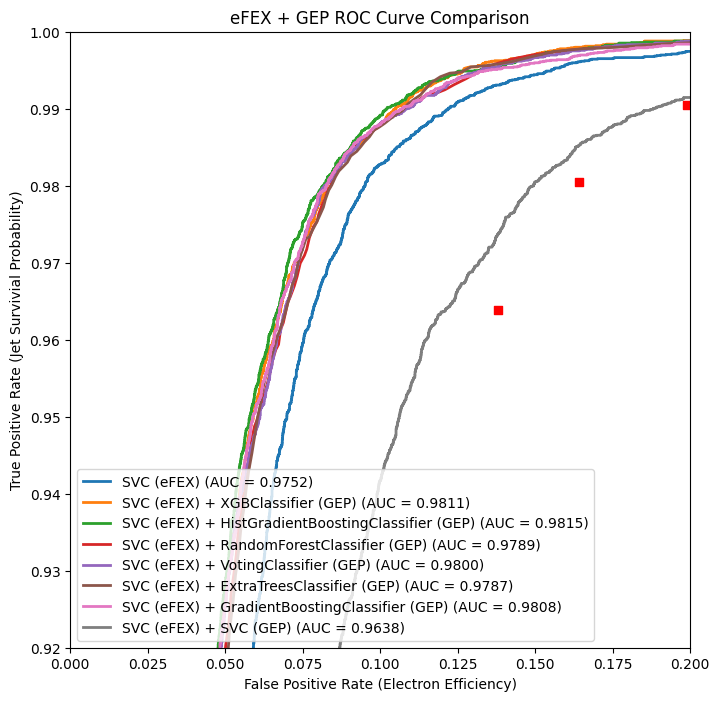

In [7]:
name = "XGBClassifier"
data_subdir = "eFEX_GEP_test"
accept_data_filename = "l1calo_topocluster_test_Zee.root"
reject_data_filename = "ZMUMU_TopoCluster_Supercell_Large.root"
distance_boundaries = [0.0125,0.025,0.05,0.1,0.2,0.4]

classifiers_1 = ["SVC"]
classifiers_2 = ["XGBClassifier","HistGradientBoostingClassifier","RandomForestClassifier","VotingClassifier","ExtraTreesClassifier","GradientBoostingClassifier","SVC"]

eFEX_GEP_loop(classifiers_1,classifiers_2,accept_data_filename,reject_data_filename,distance_boundaries,data_subdir)